In [1]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import os, sys, shutil, math, h5py


In [4]:
HOUSEHOLD_INPUT_PATH = r'H:\Tableau\HHSurvey2017'
MODEL_INPUT_PATH = r'U:\angela\job_housing\soundcast_2050\job_housing_commute\final_set'

In [15]:
hh_weight = pd.read_csv(os.path.join(HOUSEHOLD_INPUT_PATH,r'PSRC_Weights_Delivered_06132018_hh.csv'))
hh = pd.read_csv(os.path.join(HOUSEHOLD_INPUT_PATH, r'published_survey_2017\2017-pr2-1-household.csv'))
trip = pd.read_csv(os.path.join(HOUSEHOLD_INPUT_PATH, r'published_survey_2017\2017-pr2-5-trip.csv'))
person = pd.read_csv(os.path.join(HOUSEHOLD_INPUT_PATH, r'published_survey_2017\2017-pr2-2-person.csv'))

In [92]:
my_trip = trip[['hhid', 'personid', 'pernum', 'tripid', 'hhgroup', 'nwkdays','trip_path_distance',
                'depart_time_mam', 'arrival_time_mam', 'google_duration', 'origin_purpose', 'dest_purpose', 
                'mode_1', 'travelers_hh', 'travelers_nonhh', 'travelers_total', 'dayofweek', 'o_taz2010', 'd_taz2010', 
                'hh_day_wt_revised', 'trip_weight_revised']]

In [94]:
my_trip['hbw_trips'] = 0
my_trip.ix[(((my_trip['origin_purpose']==1) & (my_trip['dest_purpose']==11)) | ((my_trip['origin_purpose']==1) & (my_trip['dest_purpose']==12)) | ((my_trip['origin_purpose']==1) & (my_trip['dest_purpose']==14))  ),'hbw_trips']= 1

C:\Users\Angela\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [201]:
hbw = my_trip[my_trip['hbw_trips']==1]

In [212]:
hbw['trip_path_distance'] = pd.to_numeric(hbw['trip_path_distance'], errors='raise')
hbw['trip_path_distance_wt'] = hbw['trip_path_distance'] * hbw['trip_weight_revised']

print 'weighted mean distance in the region: ', hbw['trip_path_distance_wt'].sum()/hbw['trip_weight_revised'].sum()

weighted mean distance in the region:  11.7969861398


C:\Users\Angela\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Angela\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [206]:
hbw_groupby = hbw[['o_taz2010', 'd_taz2010', 'trip_path_distance_wt', 'trip_weight_revised']].groupby('o_taz2010').sum()
hbw_groupby.reset_index(inplace=True)
hbw_groupby['mean_trip_path_distance'] = hbw_groupby['trip_path_distance_wt'] / hbw_groupby['trip_weight_revised']

In [214]:
hbw_groupby.head()

,o_taz2010,d_taz2010,trip_path_distance_wt,trip_weight_revised,mean_trip_path_distance
0,3.0,9031.0,1324.790375,311.538055,4.252419
1,4.0,3366.0,374.714081,39.460652,9.495892
2,23.0,5374.0,516.410604,32.593691,15.843882
3,24.0,457.0,0.000000,0.000000,NaN
4,25.0,281.0,633.393726,191.937493,3.300000


# 2014 model output 

In [141]:
year = '2014'
scenario = 'stc'
hh_tot = 'hh_' + year
TAZ_file = 'commute_taz_' + year + '_30mins_' + scenario + '.csv'
print TAZ_file
taz_df = pd.read_csv(os.path.join(MODEL_INPUT_PATH, TAZ_file))

commute_taz_2014_30mins_stc.csv


In [191]:
model_df = taz_df[['mean_dist','mean_time', hh_tot,'job_housing_ratio', 'TAZ_P', 'county_id']]

In [196]:
model_df['mean_dist'].mean()

11.17821238095094

# compare difference

In [231]:
survey_n_model = pd.merge(left = model_df, right = hbw_groupby, left_on='TAZ_P', right_on = 'o_taz2010', how = 'right')

In [232]:
survey_n_model.to_csv(os.path.join(MODEL_INPUT_PATH, '2017HHsurvey_TAZ_commute_distance.csv'))

In [233]:
survey_n_model['diff'] = survey_n_model['mean_dist'] - survey_n_model['mean_trip_path_distance']

In [234]:
survey_n_model.columns

Index([u'mean_dist', u'mean_time', u'hh_2014', u'job_housing_ratio', u'TAZ_P',
       u'county_id', u'o_taz2010', u'd_taz2010', u'trip_path_distance_wt',
       u'trip_weight_revised', u'mean_trip_path_distance', u'diff'],
      dtype='object')

In [235]:
len(np.unique(survey_n_model['o_taz2010']))

233

[-50, 50, 0, 20000]

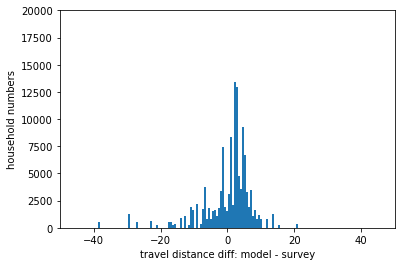

In [253]:
my_df = survey_n_model[['job_housing_ratio', hh_tot, 'diff']]
my_df = survey_n_model.dropna()
y = my_df[hh_tot]
plt.hist(my_df['diff'], bins=100, weights=y, histtype='bar', color=None)
plt.ylabel("household numbers")
plt.xlabel("travel distance diff: model - survey")
plt.axis([-50, 50, 0, 20000]) 

[0, 2.5, 0, 20000]

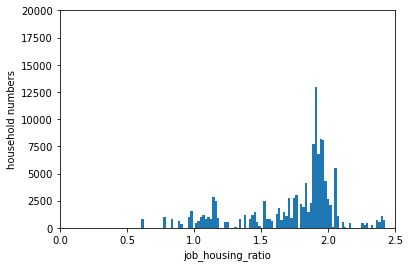

In [250]:
my_df = survey_n_model[['job_housing_ratio', hh_tot, 'diff']]
my_df = survey_n_model.dropna()
y = my_df[hh_tot]
plt.hist(my_df['job_housing_ratio'], bins=100, weights=y, histtype='bar', color=None)
plt.ylabel("household numbers")
plt.xlabel("job_housing_ratio")
plt.axis([0, 2.5, 0, 20000]) 

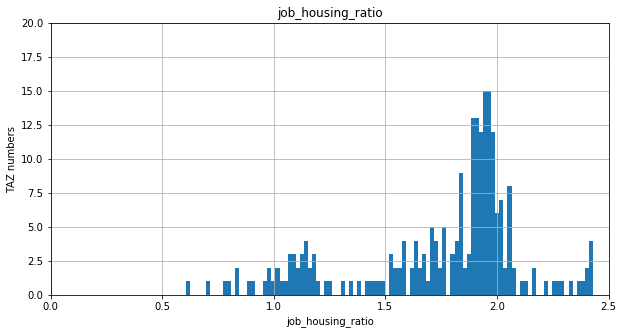

In [254]:
my_df = survey_n_model[survey_n_model['diff']!=0][['job_housing_ratio']]
my_df.hist(bins=100, figsize=(10,5))
plt.axis([0,2.5, 0, 20]) 
plt.ylabel("TAZ numbers")
plt.xlabel("job_housing_ratio")
plt.show()

[0, 2.5, -50, 50]

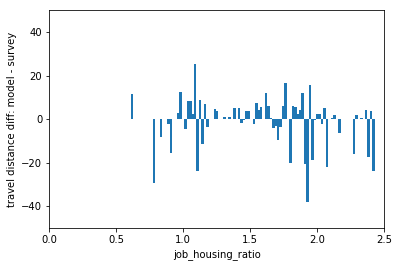

In [252]:
my_df = survey_n_model[['job_housing_ratio', hh_tot, 'diff']]
my_df = survey_n_model.dropna()
y = my_df['diff']
plt.hist(my_df['job_housing_ratio'], bins=100, weights=y, histtype='bar', color=None)
plt.ylabel("travel distance diff: model - survey")
plt.xlabel("job_housing_ratio")
plt.axis([0, 2.5, -50, 50]) 

# county level analysis

In [215]:
my_hh = hh[['hhid', 'hhgroup', 'hhsize', 'numworkers', 'sample_county', 'final_home_taz2010', 'hh_day_wt_revised']]

In [216]:
my_person = person[['hhid', 'personid', 'work_taz2010', 'hh_day_wt_revised']]

In [222]:
hh_hbw = pd.merge (left = hbw_groupby, right = my_hh, left_on = 'o_taz2010', right_on = 'final_home_taz2010', how = 'left')


In [223]:
hh_hbw.columns

Index([u'o_taz2010', u'd_taz2010', u'trip_path_distance_wt',
       u'trip_weight_revised', u'mean_trip_path_distance', u'hhid', u'hhgroup',
       u'hhsize', u'numworkers', u'sample_county', u'final_home_taz2010',
       u'hh_day_wt_revised'],
      dtype='object')

In [224]:
hh_hbw.head()

,o_taz2010,d_taz2010,trip_path_distance_wt,trip_weight_revised,mean_trip_path_distance,hhid,hhgroup,hhsize,numworkers,sample_county,final_home_taz2010,hh_day_wt_revised
0,3.0,9031.0,1324.790375,311.538055,4.252419,17100939.0,2.0,4.0,1.0,King,3.0,13.650429
1,3.0,9031.0,1324.790375,311.538055,4.252419,17102275.0,1.0,2.0,1.0,King,3.0,0.000000
2,3.0,9031.0,1324.790375,311.538055,4.252419,17107602.0,2.0,1.0,0.0,King,3.0,17.327455
3,3.0,9031.0,1324.790375,311.538055,4.252419,17110071.0,2.0,2.0,2.0,King,3.0,294.210600
4,3.0,9031.0,1324.790375,311.538055,4.252419,17118879.0,2.0,1.0,1.0,King,3.0,13.470713


In [225]:
hh_hbw['weighted_workers'] = hh_hbw['numworkers']* hh_hbw['hh_day_wt_revised']
hh_hbw['weighted_workers_distance'] = hh_hbw['weighted_workers'] * hh_hbw['mean_trip_path_distance']

In [259]:
hh_hbw_groupby_size = hh_hbw[['sample_county', 'o_taz2010', 'd_taz2010', 
                         'weighted_workers_distance', 
                         'weighted_workers']].groupby('sample_county').size()

In [260]:
hh_hbw_groupby_size

sample_county
King         1816
Kitsap          4
Pierce         19
Snohomish      14
dtype: int64

In [261]:
hh_hbw_groupby = hh_hbw[['sample_county', 'o_taz2010', 'd_taz2010', 
                         'weighted_workers_distance', 
                         'weighted_workers']].groupby('sample_county').sum()

In [262]:
hh_hbw_groupby

,o_taz2010,d_taz2010,weighted_workers_distance,weighted_workers
sample_county,,,,
King,1314110.0,6028930.0,2.507426e+06,228725.015026
Kitsap,14514.0,24886.0,1.683605e+04,1543.500939
Pierce,57293.0,115349.0,6.155252e+05,55057.756503
Snohomish,33248.0,21541.0,1.346929e+05,7588.118336


In [263]:
hh_hbw_groupby['averaged_workers_distance'] = hh_hbw_groupby['weighted_workers_distance'] / hh_hbw_groupby['weighted_workers']

In [264]:
hh_hbw_groupby

,o_taz2010,d_taz2010,weighted_workers_distance,weighted_workers,averaged_workers_distance
sample_county,,,,,
King,1314110.0,6028930.0,2.507426e+06,228725.015026,10.962623
Kitsap,14514.0,24886.0,1.683605e+04,1543.500939,10.907703
Pierce,57293.0,115349.0,6.155252e+05,55057.756503,11.179627
Snohomish,33248.0,21541.0,1.346929e+05,7588.118336,17.750501


In [265]:
model_df.groupby('county_id').mean()

,mean_dist,mean_time,hh_2014,job_housing_ratio,TAZ_P
county_id,,,,,
33.0,10.041719,26.807117,431.922112,1.639959,1060.933089
35.0,8.949723,21.178843,425.435345,1.056824,3584.116379
53.0,12.832631,31.126679,435.224460,1.006837,3070.224460
61.0,13.760603,33.428755,486.096661,1.026192,2379.397188
